# Basic Usage

Basic Usage Examples for torch-sla

This example demonstrates:
1. Creating SparseTensor from various sources
2. Sparsity pattern visualization with spy()
3. Property detection (symmetry, positive definiteness)
4. Matrix operations (multiplication, norms, eigenvalues)
5. Solve operations and gradients

In [1]:
import sys
sys.path.insert(0, '..')

import torch
from torch_sla import SparseTensor, spsolve


# =============================================================================
# 1. Creation
# =============================================================================

## 1 Create Sparse

Create SparseTensor from COO format.

In [2]:
# Create a simple 3x3 SPD tridiagonal matrix
# [4, -1,  0]
# [-1, 4, -1]
# [0, -1,  4]
val = torch.tensor([4.0, -1.0, -1.0, 4.0, -1.0, -1.0, 4.0], dtype=torch.float64)
row = torch.tensor([0, 0, 1, 1, 1, 2, 2])
col = torch.tensor([0, 1, 0, 1, 2, 1, 2])
shape = (3, 3)

# Create SparseTensor
A = SparseTensor(val, row, col, shape)
print(f"Created: {A}")
print(f"Dense form:\n{A.to_dense()}")

Created: SparseTensor(shape=(3, 3), sparse=(3, 3), nnz=7, dtype=torch.float64, device=cpu)
Dense form:
tensor([[ 4., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  4.]], dtype=torch.float64)


## 2 From Dense

Create SparseTensor from dense matrix.

In [3]:
# Create a random sparse matrix
n = 100
A_dense = torch.randn(n, n, dtype=torch.float64)
A_dense = A_dense @ A_dense.T  # Make symmetric
A_dense[A_dense.abs() < 1.0] = 0  # Sparsify
A_dense += torch.eye(n) * n  # Make positive definite

# Convert to SparseTensor
A = SparseTensor.from_dense(A_dense)
print(f"Created from dense: {A}")
print(f"Sparsity: {1 - A.nnz / (n * n):.1%}")

Created from dense: SparseTensor(shape=(100, 100), sparse=(100, 100), nnz=9188, dtype=torch.float64, device=cpu)
Sparsity: 8.1%


## 3 Spy Visualization

Visualize sparsity patterns with spy().

2D Poisson matrix: SparseTensor(shape=(400, 400), sparse=(400, 400), nnz=1920, dtype=torch.float64, device=cpu)
Sparsity: 98.8%


/minimax-dialogue/users/walker/.config/matplotlib is not a writable directory


Matplotlib created a temporary cache directory at /tmp/matplotlib-7mql42w8 because there was an issue with the default path (/minimax-dialogue/users/walker/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Matplotlib is building the font cache; this may take a moment.


/minimax-dialogue/users/walker/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Saved spy plots to figures/


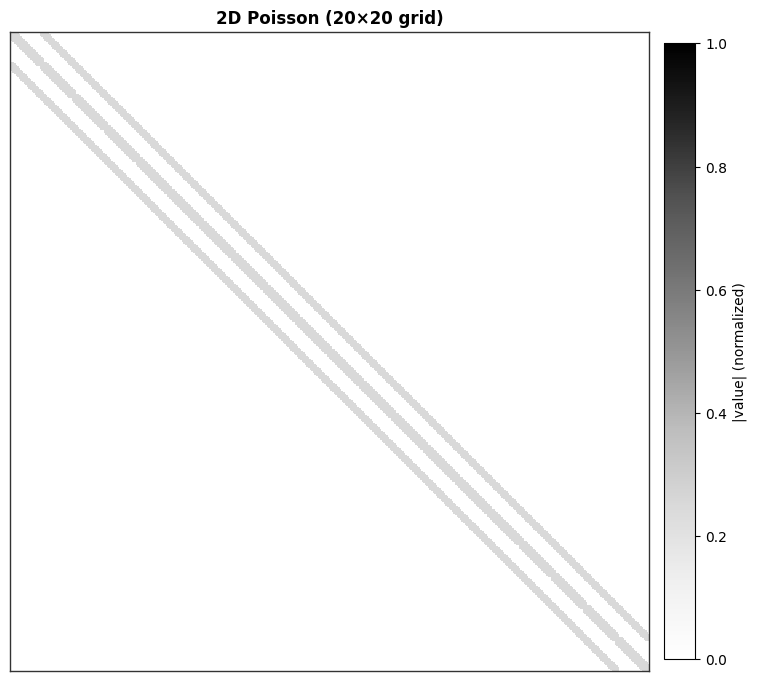

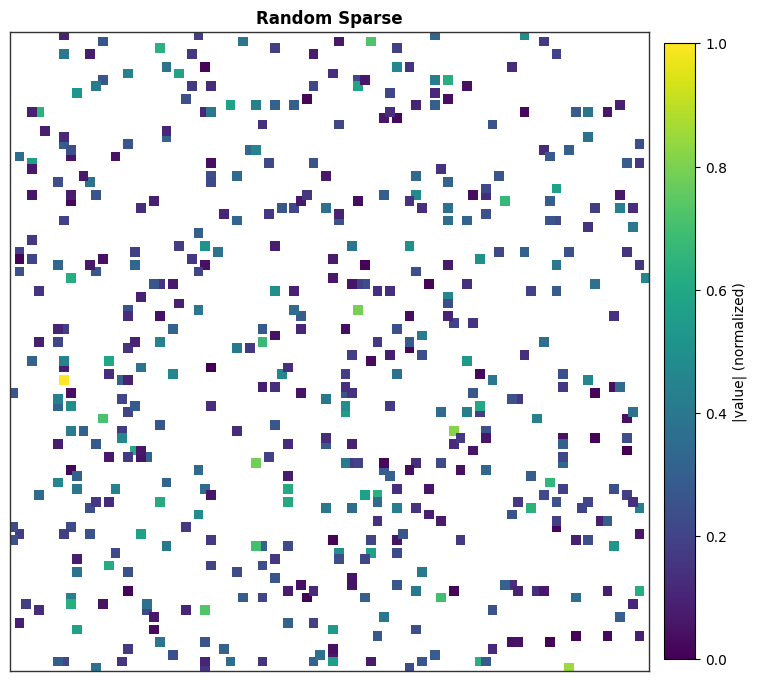

In [4]:
# Create a 2D Poisson matrix (5-point stencil)
n = 20
N = n * n
idx = torch.arange(N)
i, j = idx // n, idx % n

# Build COO indices
diag_val = torch.full((N,), 4.0, dtype=torch.float64)
left_mask = j > 0
right_mask = j < n - 1
up_mask = i > 0
down_mask = i < n - 1

row = torch.cat([idx, idx[left_mask], idx[right_mask], idx[up_mask], idx[down_mask]])
col = torch.cat([idx, idx[left_mask] - 1, idx[right_mask] + 1, idx[up_mask] - n, idx[down_mask] + n])
val = torch.cat([
    diag_val,
    torch.full((left_mask.sum(),), -1.0, dtype=torch.float64),
    torch.full((right_mask.sum(),), -1.0, dtype=torch.float64),
    torch.full((up_mask.sum(),), -1.0, dtype=torch.float64),
    torch.full((down_mask.sum(),), -1.0, dtype=torch.float64),
])

A = SparseTensor(val, row, col, (N, N))
print(f"2D Poisson matrix: {A}")
print(f"Sparsity: {1 - A.nnz / (N * N):.1%}")

# Visualize sparsity pattern
try:
    import matplotlib

    import matplotlib.pyplot as plt
    
    # 1. Basic spy plot
    A.spy(title=f'2D Poisson ({n}×{n} grid)', cmap='Greys')

    # 2. Random sparse matrix for comparison
    nnz = 500
    B = SparseTensor(
        torch.randn(nnz, dtype=torch.float64),
        torch.randint(0, 100, (nnz,)),
        torch.randint(0, 100, (nnz,)),
        (100, 100)
    )
    B.spy(title='Random Sparse', cmap='viridis')

    print("Saved spy plots to figures/")
    
except ImportError:
    print("matplotlib not available, skipping visualization")

## 4 Property Detection

Detect matrix properties.

In [5]:
# Create SPD matrix
val = torch.tensor([4.0, -1.0, -1.0, 4.0, -1.0, -1.0, 4.0], dtype=torch.float64)
row = torch.tensor([0, 0, 1, 1, 1, 2, 2])
col = torch.tensor([0, 1, 0, 1, 2, 1, 2])

A = SparseTensor(val, row, col, (3, 3))

# Property checks
print(f"Matrix A:\n{A.to_dense()}")
print(f"\nIs symmetric: {A.is_symmetric()}")
print(f"Is positive definite (Gershgorin): {A.is_positive_definite('gershgorin')}")
print(f"Is positive definite (Cholesky): {A.is_positive_definite('cholesky')}")

# Non-symmetric matrix
val_nonsym = torch.tensor([4.0, -1.0, -2.0, 4.0], dtype=torch.float64)
row_nonsym = torch.tensor([0, 0, 1, 1])
col_nonsym = torch.tensor([0, 1, 0, 1])

B = SparseTensor(val_nonsym, row_nonsym, col_nonsym, (2, 2))
print(f"\nMatrix B (non-symmetric):\n{B.to_dense()}")
print(f"Is symmetric: {B.is_symmetric()}")

Matrix A:
tensor([[ 4., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  4.]], dtype=torch.float64)

Is symmetric: True
Is positive definite (Gershgorin): True
Is positive definite (Cholesky): True

Matrix B (non-symmetric):
tensor([[ 4., -1.],
        [-2.,  4.]], dtype=torch.float64)
Is symmetric: False


## 5 Matrix Multiplication

Matrix multiplication operations.

In [6]:
# Create sparse matrix
val = torch.tensor([4.0, -1.0, -1.0, 4.0, -1.0, -1.0, 4.0], dtype=torch.float64)
row = torch.tensor([0, 0, 1, 1, 1, 2, 2])
col = torch.tensor([0, 1, 0, 1, 2, 1, 2])
A = SparseTensor(val, row, col, (3, 3))
A_dense = A.to_dense()

# Sparse @ Dense vector
x = torch.randn(3, dtype=torch.float64)
y = A @ x
print(f"Sparse @ Dense vector: correct = {torch.allclose(y, A_dense @ x)}")

# Sparse @ Dense matrix
X = torch.randn(3, 5, dtype=torch.float64)
Y = A @ X
print(f"Sparse @ Dense matrix: correct = {torch.allclose(Y, A_dense @ X)}")

# Dense @ Sparse
y = x @ A
print(f"Dense @ Sparse: correct = {torch.allclose(y, x @ A_dense)}")

# Sparse @ Sparse
B = SparseTensor(val.clone(), row.clone(), col.clone(), (3, 3))
C = A @ B
print(f"Sparse @ Sparse: correct = {torch.allclose(C.to_dense(), A_dense @ A_dense)}")

Sparse @ Dense vector: correct = True
Sparse @ Dense matrix: correct = True
Dense @ Sparse: correct = True
Sparse @ Sparse: correct = True


/minimax-dialogue/users/walker/projects/torch-sla/examples/../torch_sla/sparse_tensor.py:333: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  C_coo = torch.sparse.mm(A_coo, B_coo).coalesce()


## 6 Norms And Eigenvalues

Norms, eigenvalues, and SVD.

In [7]:
# Create tridiagonal matrix
n = 30
idx = torch.arange(n)

diag_val = torch.full((n,), 4.0, dtype=torch.float64)
off_val = torch.full((n - 1,), -1.0, dtype=torch.float64)

row = torch.cat([idx, idx[1:], idx[:-1]])
col = torch.cat([idx, idx[:-1], idx[1:]])
val = torch.cat([diag_val, off_val, off_val])

A = SparseTensor(val, row, col, (n, n))

# Norms
print(f"Frobenius norm: {A.norm('fro'):.4f}")

# Eigenvalues
eigenvalues, _ = A.eigsh(k=5, which='LM')
print(f"Largest 5 eigenvalues: {eigenvalues.tolist()}")

# SVD
U, S, Vt = A.svd(k=5)
print(f"Largest 5 singular values: {S.tolist()}")

# Condition number
cond = A.condition_number(ord=2)
print(f"Condition number: {cond:.4f}")

Frobenius norm: 23.1948


Largest 5 eigenvalues: [5.748693232289163, 5.837915623240461, 5.9082785128000985, 5.95905988250499, 5.989738646783791]
Largest 5 singular values: [5.748693232289165, 5.837915623240463, 5.908278512800098, 5.959059882504989, 5.989738646783791]
Condition number: 1.0617


## 7 Basic Solve

Basic sparse linear solve.

In [8]:
val = torch.tensor([4.0, -1.0, -1.0, 4.0, -1.0, -1.0, 4.0], dtype=torch.float64)
row = torch.tensor([0, 0, 1, 1, 1, 2, 2])
col = torch.tensor([0, 1, 0, 1, 2, 1, 2])

A = SparseTensor(val, row, col, (3, 3))
b = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64)

# Solve Ax = b
x = A.solve(b)
print(f"Solution x: {x}")

# Verify
residual = A @ x - b
print(f"Residual ||Ax - b||: {residual.norm():.2e}")

Solution x: tensor([0.4643, 0.8571, 0.9643], dtype=torch.float64)
Residual ||Ax - b||: 4.44e-16


## 8 Gradient Through Solve

Compute gradients through sparse solve.

In [9]:
# Create matrix with gradient tracking
val = torch.tensor([4.0, -1.0, -1.0, 4.0, -1.0, -1.0, 4.0], 
                   dtype=torch.float64, requires_grad=True)
row = torch.tensor([0, 0, 1, 1, 1, 2, 2])
col = torch.tensor([0, 1, 0, 1, 2, 1, 2])

b = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64, requires_grad=True)

# Solve
x = spsolve(val, row, col, (3, 3), b)

# Backpropagate
loss = x.sum()
loss.backward()

print(f"Solution x: {x.tolist()}")
print(f"∂L/∂val: {val.grad.tolist()}")
print(f"∂L/∂b: {b.grad.tolist()}")

Solution x: [0.4642857142857143, 0.8571428571428571, 0.9642857142857143]
∂L/∂val: [-0.16581632653061226, -0.30612244897959184, -0.1989795918367347, -0.36734693877551017, -0.41326530612244894, -0.3061224489795918, -0.3443877551020408]
∂L/∂b: [0.35714285714285715, 0.42857142857142855, 0.3571428571428571]


## 9 Sparse Gradient

Sparse @ Sparse with sparse gradient.

In [10]:
# Create matrices with gradient tracking
val_a = torch.tensor([1.0, 2.0, 3.0, 4.0], dtype=torch.float64, requires_grad=True)
row_a = torch.tensor([0, 0, 1, 1])
col_a = torch.tensor([0, 1, 0, 1])
A = SparseTensor(val_a, row_a, col_a, (2, 2))

val_b = torch.tensor([1.0, 2.0], dtype=torch.float64, requires_grad=True)
row_b = torch.tensor([0, 1])
col_b = torch.tensor([0, 1])
B = SparseTensor(val_b, row_b, col_b, (2, 2))

# Sparse @ Sparse
C = A @ B
loss = C.to_dense().sum()
loss.backward()

print(f"A @ B = \n{C.to_dense()}")
print(f"\nGradients (SPARSE - same size as input values):")
print(f"  val_a.grad: {val_a.grad.tolist()}")
print(f"  val_b.grad: {val_b.grad.tolist()}")

A @ B = 
tensor([[1., 4.],
        [3., 8.]], dtype=torch.float64, grad_fn=<ToDenseBackward0>)

Gradients (SPARSE - same size as input values):
  val_a.grad: [1.0, 2.0, 1.0, 2.0]
  val_b.grad: [4.0, 6.0]


## 10 Batched Operations

Batched operations.

In [11]:
n = 10
idx = torch.arange(n)

# Create tridiagonal matrix
diag_val = torch.full((n,), 4.0, dtype=torch.float64)
off_val = torch.full((n - 1,), -1.0, dtype=torch.float64)

row = torch.cat([idx, idx[1:], idx[:-1]])
col = torch.cat([idx, idx[:-1], idx[1:]])
val = torch.cat([diag_val, off_val, off_val])

# Create batched tensor [B, M, N]
batch_size = 4
val_batch = val.unsqueeze(0).expand(batch_size, -1).clone()
for i in range(batch_size):
    val_batch[i] = val * (1 + 0.1 * i)

A_batch = SparseTensor(val_batch, row, col, (batch_size, n, n))
print(f"Batched SparseTensor: {A_batch}")

# Batched solve
b_batch = torch.randn(batch_size, n, dtype=torch.float64)
x_batch = A_batch.solve(b_batch)
print(f"Batched solve output shape: {x_batch.shape}")

# Batched properties
print(f"Batched is_symmetric: {A_batch.is_symmetric()}")
print(f"Batched norms: {A_batch.norm('fro').tolist()}")

Batched SparseTensor: SparseTensor(shape=(4, 10, 10), batch=(4,), sparse=(10, 10), nnz=28, dtype=torch.float64, device=cpu)
Batched solve output shape: torch.Size([4, 10])
Batched is_symmetric: tensor([True, True, True, True])
Batched norms: [13.341664064126334, 14.675830470538969, 16.009996876951597, 17.344163283364235]
